**1. Data Loading:**

 loaded the IMDb movie reviews dataset using the datasets library.The dataset is already divided into training and testing sets with 25,000 samples each. printed a sample review and its label to understand the structure of the text data and verify that the dataset is loaded correctly.

In [ ]:
from datasets import load_dataset

#Loading datasets Dataset
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

# A sample checking .
print("\nSample Data Check:")
print(f"Text: {train_data[0]['text'][:100]}...") # first 100 characters
print(f"Label: {train_data[0]['label']} (0=Negative, 1=Positive)")

Train samples: 25000, Test samples: 25000

Sample Data Check:
Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...
Label: 0 (0=Negative, 1=Positive)


**2.Data Preprocessing:**

created a custom tokenization function.
It cleans the text by removing unwanted characters, separates punctuation, converts text to lowercase, and finally splits the text into individual words.
This preprocessing step helps the model understand text data in a structured way.

In [ ]:
import re

def tokenize(text):#converts raw text into words(tokens)
    # 1.adding space arround  Punctuation. (e.g. "good!" -> "good !")
    text = re.sub(r"([.!?])", r" \1 ", text)
    # 2. removing Unwanted characters
    text = re.sub(r"[^a-zA-Z.!?]+", r" ", text)
    # 3. Lowercase and split
    return text.lower().split()

created a vocabulary from the training data.
I counted the frequency of each word and selected the top 20,000 most common words.Then, converted each word into a numerical index and added special tokens for padding and unknown words.
Finally, saved the vocabulary mapping for future use.

In [ ]:
word_freq = {} # counts how many times every words comes.
for item in train_data:
    for word in tokenize(item["text"]):
        word_freq[word] = word_freq.get(word, 0) + 1

MAX_VOCAB_SIZE = 20000
vocab = sorted(word_freq, key=word_freq.get, reverse=True)[:MAX_VOCAB_SIZE]


word2idx = {word: idx + 2 for idx, word in enumerate(vocab)} # coverts words in vocabulary into a unique numbers
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

vocab_size = len(word2idx)
print("Vocab Size:", vocab_size)

import pickle
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
print("word2idx.pkl saved successfully with <PAD> and <UNK> tokens")

Vocab Size: 20002
word2idx.pkl saved successfully with <PAD> and <UNK> tokens


converted raw text into numerical tensors.
First, the text is tokenized and each word is mapped to its corresponding index.Unknown words are replaced with a special token.
Then, I apply truncation and padding so that all inputs have the same length.Finally, the output is converted into a PyTorch tensor for model training.

In [ ]:
from collections import Counter

import torch # importing pytorch lib for making tensors.

MAX_LEN = 150 #  Fixing every review maximum 150 words

def encode(text): #function will convert raw texts into tensor.

    tokens = tokenize(text)

    encoded = [word2idx.get(word, 1) for word in tokens]

    # 3. Did Truncation means Cutting extra words beyond a fixed limit.
    encoded = encoded[:MAX_LEN]

  #If a sentence is shorter than the maximum length, padding tokens with value 0.
    if len(encoded) < MAX_LEN:
        padding_len = MAX_LEN - len(encoded)
        encoded.extend([0] * padding_len)

    return torch.tensor(encoded) # converted Final list into PyTorch tensor.



created a custom Dataset class in PyTorch for the IMDb data.
It stores the movie reviews and their labels.
Whenever PyTorch needs data, this class converts the text into numbers and returns it along with the label.
This makes it easy for PyTorch to load and use the data during training and testing.

In [ ]:
from torch.utils.data import Dataset, DataLoader # importing pytorch tools.

class IMDbDataset(Dataset):#A custom Dataset class defines the structure of the data and tells PyTorch how to load each input and label.
    def __init__(self, data):
        # Storing only raw texts and labels.
        self.texts = [item["text"] for item in data]
        self.labels = [item["label"] for item in data]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        text = self.texts[idx]
        label = self.labels[idx]
        return encode(text), torch.tensor(label)



I created DataLoaders for the training and testing data.
The DataLoader sends the data to the model in small batches instead of all at once.Training data is shuffled so the model learns better, while test data is kept in the same order to check performance correctly.

In [ ]:


train_loader = DataLoader(
    IMDbDataset(train_data),
    batch_size=32,
    shuffle=True
)

test_loader = DataLoader(
    IMDbDataset(test_data),
    batch_size=32,
    shuffle=False
)



**3.Building the Custom LSTM Model:**

In this cell, I built a custom LSTM model for sentiment analysis.
First, words are converted into embeddings.Then, the LSTM processes the sentence and captures its meaning.The final hidden state is passed through a fully connected layer and a sigmoid function to predict whether the sentiment is positive or negative

In [ ]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        # padding_idx=0 ignores padding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)

        # Sigmoid activation for binary output (0 to 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.embedding(x)


        _, (hidden, _) = self.lstm(x)


        out = self.fc(hidden[-1]) #for finding hidden state of last layer

        return self.sigmoid(out)

I set up the model for training.I defined the hyperparameters, initialized the LSTM model, selected a loss function, and used the Adam optimizer.I also checked the available hardware and moved the model to CPU or GPU for efficient training.

In [ ]:
import torch.optim as optim

# Model Hyperparameters
EMBED_DIM = 128
HIDDEN_DIM = 128
LR = 0.001

#  Initializing the model
model = SentimentLSTM(vocab_size, EMBED_DIM, HIDDEN_DIM)

# Loss Function: BCELoss (Binary Cross Entropy) best for binary classification
criterion = nn.BCELoss()

# Using Adam optimizer for faster convergence .
optimizer = optim.Adam(model.parameters(), lr=LR)

# Hardware Checking:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model is using: {device}")
print(model)

Model is using: cuda
SentimentLSTM(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


**4.Training and Optimization:**

I trained the model using a training loop.The model learns over multiple epochs by processing data in batches.For each batch, the model makes predictions, calculates loss, and updates its weights using backpropagation.The average loss is printed after each epoch to monitor learning progress.

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(texts)

        # To avoid batch-size 1 error
        outputs = outputs.view(-1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.4f}")

Epoch 1/5, Average Loss: 0.6820
Epoch 2/5, Average Loss: 0.6452
Epoch 3/5, Average Loss: 0.6174
Epoch 4/5, Average Loss: 0.5679
Epoch 5/5, Average Loss: 0.4568


**5.Model Evaluation:**

I evaluated the trained model on test data.The model makes predictions without learning and outputs probabilities.Based on these predictions, I calculated accuracy, precision, recall, and F1 score.Additionally, I performed a neutral analysis to identify reviews where the model was unsure, which helps in understanding mixed sentiments.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_probs = []
true_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model(texts).view(-1)

        # Probs store kar rahe hain neutral analysis ke liye
        all_probs.extend(outputs.cpu().tolist())

        # Binary predictions for standard metrics
        preds = (outputs > 0.5).int()
        all_preds.extend(preds.cpu().tolist())
        true_labels.extend(labels.tolist())

# Metrics Calculation
acc = accuracy_score(true_labels, all_preds)
prec = precision_score(true_labels, all_preds)
rec = recall_score(true_labels, all_preds)
f1 = f1_score(true_labels, all_preds)

print(f"--- Standard Metrics ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Neutral Zone Analysis (Presentation ke liye important)
neutral_count = sum(1 for p in all_probs if 0.4 <= p <= 0.6)
print(f"\n--- Neutral Analysis ---")
print(f"Total Test Samples: {len(all_probs)}")
print(f"Samples in 'Neutral/Mixed' Zone (0.4-0.6): {neutral_count}")
print(f"Percentage of Mixed Reviews: {(neutral_count/len(all_probs))*100:.2f}%")

--- Standard Metrics ---
Accuracy:  0.7813
Precision: 0.7921
Recall:    0.7629
F1 Score:  0.7772

--- Neutral Analysis ---
Total Test Samples: 25000
Samples in 'Neutral/Mixed' Zone (0.4-0.6): 1753
Percentage of Mixed Reviews: 7.01%


**6.Model Optimization (AWD-LSTM Techniques):**

I implemented variational dropout in the model.Instead of changing dropout at every step, it uses the same dropout pattern for the whole sentence.This helps the LSTM learn better, avoids overfitting, and keeps training stable.

In [ ]:
import torch
import torch.nn as nn

class VariationalDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        #  It apply same mask every time-step in training.
        if not self.training or not self.p:
            return x
        mask = x.new_empty(x.size(0), 1, x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div(1 - self.p)
        return x * mask

In this model, I implemented an AWD-LSTM architecture.First, words are converted into embeddings.Then, the sentence is passed through multiple LSTM layers to capture deeper context.After each layer, variational dropout is applied to reduce overfitting.Finally, the last hidden state is used to predict whether the review is positive or negative.

In [ ]:
class AWDLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, n_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Multiple Layers (AWD-LSTM standard)
        self.lstms = nn.ModuleList([
            nn.LSTM(embed_dim if i == 0 else hidden_dim,
                    hidden_dim, batch_first=True)
            for i in range(n_layers)
        ])

        self.var_drop = VariationalDropout(0.2)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Embedding + Dropout
        x = self.embedding(x)

        # Passing through multiple LSTM layers
        for lstm in self.lstms:
            x, (h, c) = lstm(x)
            x = self.var_drop(x)

        # Last hidden state for classification
        out = self.fc(x[:, -1, :])
        return self.sigmoid(out)

# Model initialization
model_awd = AWDLSTM(vocab_size, 200, 512).to(device)
print("AWD-LSTM Structure Created")

AWD-LSTM Structure Created


Here, I used the Adam optimizer to update the model efficiently.
Binary cross-entropy loss is used because this is a binary classification problem.I also applied a learning rate scheduler, which gradually reduces the learning rate to make training more stable and accurate.

In [ ]:
optimizer = torch.optim.Adam(model_awd.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCELoss()

# appling Learning rate scheduler will reduce lr 10 times after 2 epochs.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In this model, I implemented a Bidirectional LSTM.The sentence is read from both left to right and right to left, which helps the model understand full context.This improves sentiment prediction accuracy compared to a normal LSTM.

In [ ]:
import torch.nn as nn

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # bidirectional=True increses accuracy
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        # in bidirectional hidden_dim will double
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)

        lstm_out, _ = self.lstm(x)
        # taking output only last time-step
        out = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(out)

# Model initialize .
model_bi = BiLSTMModel(vocab_size, 128, 128).to(device)
optimizer = torch.optim.Adam(model_bi.parameters(), lr=0.001)
criterion = nn.BCELoss()

print("Bidirectional LSTM Ready for Training!")

Bidirectional LSTM Ready for Training!


Here, I trained the Bidirectional LSTM model for five epochs.
The data is processed in batches, loss is calculated, and the model updates its weights using backpropagation.After training, the final model is saved for later use and deployment.

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
    model_bi.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model_bi(texts).view(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/5, Avg Loss: {total_loss/len(train_loader):.4f}")

# Saved this for later used.
torch.save(model_bi.state_dict(), "bilstm_model.pth")

Epoch 1/5, Avg Loss: 0.6911
Epoch 2/5, Avg Loss: 0.6799
Epoch 3/5, Avg Loss: 0.6668
Epoch 4/5, Avg Loss: 0.4524
Epoch 5/5, Avg Loss: 0.3054


After training, I evaluated the Bi-LSTM model on the test data.
I calculated accuracy, precision, recall, and F1-score to measure performance.I also used a confusion matrix to clearly visualize correct and incorrect predictions.

--- Bi-LSTM Detailed Metrics ---
Accuracy:  0.8180
Precision: 0.8280
Recall:    0.8028
F1 Score:  0.8152


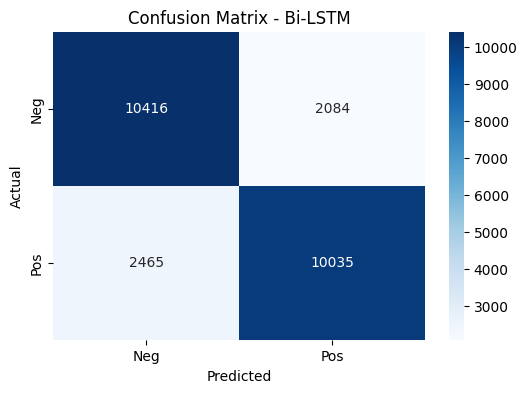

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model_bi.eval()
all_preds = []
true_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model_bi(texts).view(-1)
        preds = (outputs > 0.5).int()

        all_preds.extend(preds.cpu().tolist())
        true_labels.extend(labels.tolist())

# Metrics Calculation
acc = accuracy_score(true_labels, all_preds)
prec = precision_score(true_labels, all_preds)
rec = recall_score(true_labels, all_preds)
f1 = f1_score(true_labels, all_preds)

print(f"--- Bi-LSTM Detailed Metrics ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(true_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Bi-LSTM')
plt.show()

**Final output:** The Bidirectional LSTM model achieved an accuracy of around 82%, which shows good overall performance.The precision is 82.8%, meaning when the model predicts a review as positive, it is mostly correct.The recall is 80.2%, which shows the model is able to correctly identify most of the actual positive reviews.The F1-score is 81.5%, indicating a good balance between precision and recall.

**Confusion Matrix:** From the confusion matrix, we can see that the model correctly classified 10,416 negative reviews and 10,035 positive reviews.However, 2,084 negative reviews were wrongly predicted as positive, and 2,465 positive reviews were predicted as negative.This shows that the model performs well overall but still makes some mistakes, especially in borderline or mixed-sentiment reviews.